In [ ]:
# Align environment before loading data
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

os.chdir(Path.cwd().parent)
print("Working directory set to:", Path.cwd())

Working directory set to: /Users/rifusaki/Documents/repos/college/courses/thermodynamics


In [ ]:
# Wrap Excel access so each sheet is parsed the same way
def load_measures(excel_path):
    sheets = ["Measure 1", "Measure 2", "Measure 3"]
    data_nested = []
    for s in sheets:
        df = pd.read_excel(excel_path, sheet_name=s)
        cols = [c for c in ["ts", "TC", "TF"] if c in df.columns]
        if len(cols) < 3:
            raise ValueError(f"Missing required columns in sheet '{s}'. Found: {cols}")
        # Store timestamp plus both probe readings for plotting
        data_nested.append(df[cols].values.tolist())
    return data_nested

# Example usage:
excel_file = 'data/07_heatTransfer/data.xlsx'
measures_data = load_measures(excel_file)

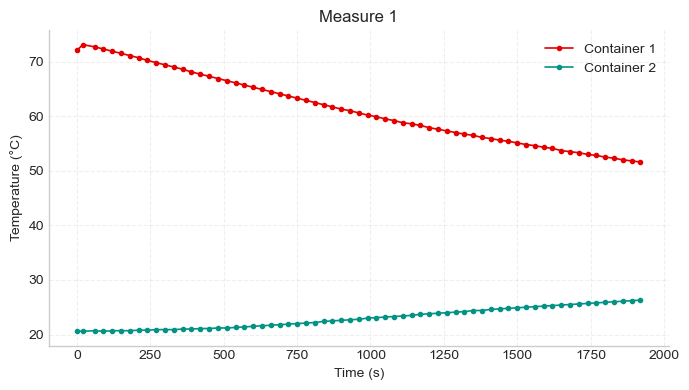

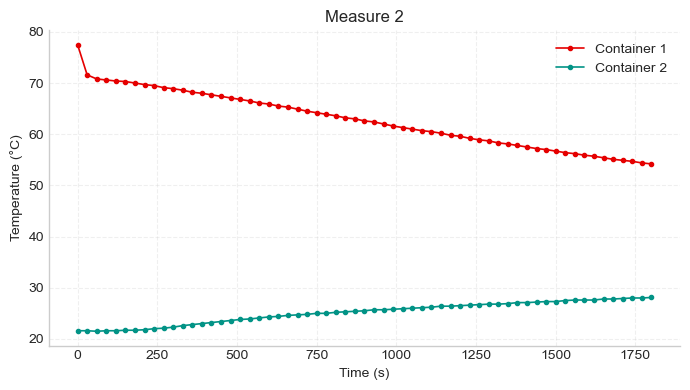

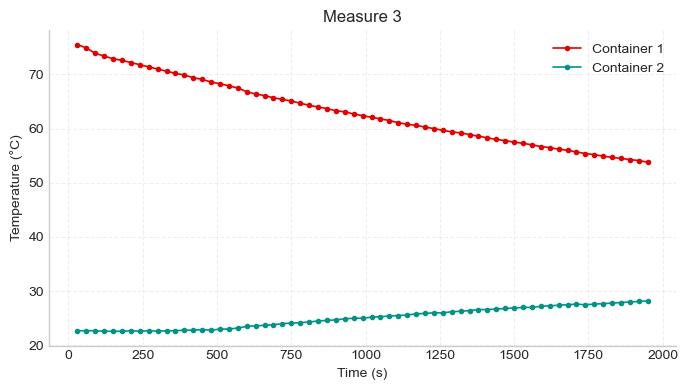

In [ ]:
sheet_names = ["Measure 1", "Measure 2", "Measure 3"]

# Plot raw temperature traces for each measure
for rows, title in zip(measures_data, sheet_names):
    fig, ax = plt.subplots(figsize=(7, 4))
    plt.style.use('seaborn-v0_8-whitegrid')
    if not rows:
        ax.set_title(f"{title} (no data)")
        ax.axis('off')
        plt.show()
        continue

    ts, tc, tf = zip(*rows)
    ax.plot(ts, tc, label='Container 1', color='xkcd:red', linewidth=1.2, marker='.')
    ax.plot(ts, tf, label='Container 2', color='xkcd:teal', linewidth=1.2, marker='.')
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3, axis='both', linestyle="--")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}_temperature_plot.png', dpi=300)
    plt.show()

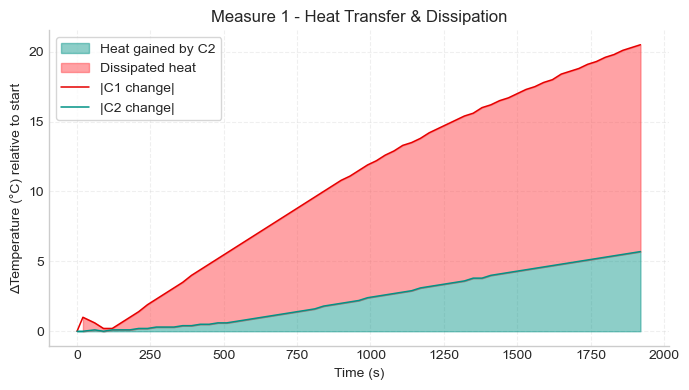

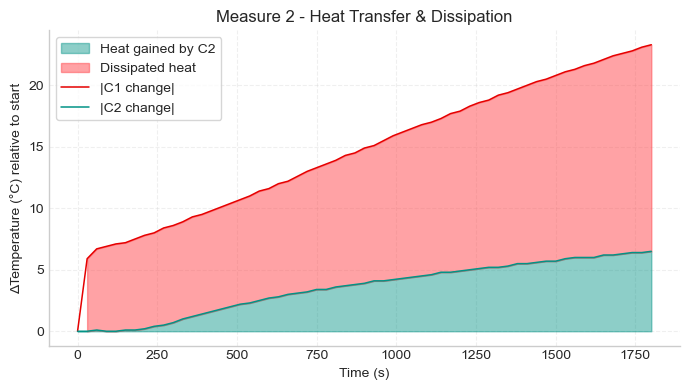

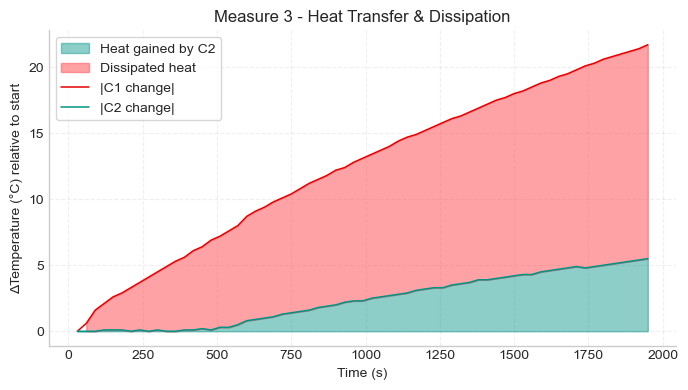

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Area graphs: visualize heat lost by TC vs gained by TF and dissipated portion.
# Assumption: Heat lost (or gained) measured as temperature change relative to first reading.
# Dissipated = (|TC change|) - (|TF change|) when TC change magnitude exceeds TF change magnitude.

sheet_names = ["Measure 1", "Measure 2", "Measure 3"]

for rows, title in zip(measures_data, sheet_names):
    if not rows:
        continue
    ts, tc, tf = zip(*rows)
    ts = np.array(ts, dtype=float)
    tc = np.array(tc, dtype=float)
    tf = np.array(tf, dtype=float)

    # Normalize readings to the starting point to estimate cumulative transfer
    tc_change = tc - tc[0]
    tf_change = tf - tf[0]

    # Compare absolute changes to approximate heat lost and gained
    tc_loss_mag = np.abs(tc_change)
    tf_gain_mag = np.abs(tf_change)

    # Dissipated portion (ensure non-negative)
    dissipated = tc_loss_mag - tf_gain_mag
    dissipated = np.clip(dissipated, 0, None)

    fig, ax = plt.subplots(figsize=(7, 4))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Stack areas: lower layer = TF gain, upper layer = dissipated (if any)
    ax.fill_between(ts, 0, tf_gain_mag, color='xkcd:teal', alpha=0.45, label='Heat gained by C2')
    ax.fill_between(ts, tf_gain_mag, tf_gain_mag + dissipated, where=dissipated > 0, color='xkcd:light red', alpha=0.5, label='Dissipated heat')

    # Overlay lines for clarity
    ax.plot(ts, tc_loss_mag, color='xkcd:red', linewidth=1.1, label='|C1 change|')
    ax.plot(ts, tf_gain_mag, color='xkcd:teal', linewidth=1.1, label='|C2 change|')

    ax.set_title(f"{title} - Heat Transfer & Dissipation")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('ΔTemperature (°C) relative to start')
    ax.grid(True, alpha=0.3, axis='both', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', frameon=True)

    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}_heat_transfer_dissipation_plot.png', dpi=300)
    plt.show()
